# Case Study: Orbital Velocities

You may have learned that the velocity of an idealized circular orbit --- a 
massless particle moving in the Newtonian gravitational field of a single 
point-mass --- is related to the radius of the orbit: to increase your orbital 
radius, increase your speed. More formally, the speed of an massless particle in 
this same idealized circular orbit can be found by taking the square root of 
the mass parameter divided by orbital radius. The planets in our solar system 
have near-circular orbits. We can compare their speeds, and recover the 
relationship that orbital speed has with orbital radius. 

$$v = \sqrt{\frac{\mu}{r}}$$

First, let's load the proper ephemeris data using `SPICEKernels`,
`SPICEBodies`, and `SPICE`. We will load the planet's _barycenters_ here:
the center of mass of their orbital system (the planet, and its moons).
Just for fun, let's include Pluto and see what happens!

In [4]:
using SPICE, SPICEKernels, SPICEBodies

furnsh(
    de440s(),                   # position and velocity data for inner planet    
    latest_leapseconds_lsk(),   # timekeeping, parsing epochs
    gm_de440(),                 # mass parameters for major solar system bodies
    pck00011(),                 # physical properties of major solar system bodies
)

mercury = KernelBody("mercury barycenter")
venus = KernelBody("venus barycenter")
earth = KernelBody("earth barycenter")
mars = KernelBody("mars barycenter")
jupiter = KernelBody("jupiter barycenter")
saturn = KernelBody("saturn barycenter")
uranus = KernelBody("uranus barycenter")
neptune = KernelBody("neptune barycenter")
pluto = KernelBody("pluto barycenter")

planets = (mercury, venus, earth, mars, jupiter, saturn, uranus, neptune, pluto)

(KernelBody(1), KernelBody(2), KernelBody(3), KernelBody(4), KernelBody(5), KernelBody(6), KernelBody(7), KernelBody(8), KernelBody(9))

All of these orbits are near circular, with the exception of Mercury, and one 
pesky ex-planet. A perfectly circular orbit will have an eccentricity of zero. 

:::{.callout-info appearance="simple"}
Mercury's orbit is non-circular due to general relativity!
:::

In [11]:
using Dates
using DataFrames
using AstrodynamicalCalculations

average_eccentricity(planet) =
    let epoch = now()
        times = epoch-Year(15):Day(1):epoch+Year(15)
        ecc(state) = AstrodynamicalCalculations.eccentricity(
            state.x,
            state.y,
            state.z,
            state.ẋ,
            state.ẏ,
            state.ż,
            gm(:sun),
        )

        return sum(time -> ecc(planet(time; wrt = :sun)), times) / length(times)
    end

name(planet) = bodc2n(SPICEBodies.naifcode(planet))

eccentricities = Dict(name(planet) => average_eccentricity(planet) for planet in planets)

Dict{String, Float64} with 9 entries:
  "MERCURY BARYCENTER" => 0.205636
  "EARTH BARYCENTER"   => 0.0166962
  "JUPITER BARYCENTER" => 0.048503
  "SATURN BARYCENTER"  => 0.0541135
  "NEPTUNE BARYCENTER" => 0.010552
  "MARS BARYCENTER"    => 0.0934244
  "VENUS BARYCENTER"   => 0.00675986
  "URANUS BARYCENTER"  => 0.0471192
  "PLUTO BARYCENTER"   => 0.249388

With their (mostly) near-circular orbits established, let's choose an epoch at 
random and plot their orbital speed, and their _expected_ orbital speed due to 
the idealized calculation. 

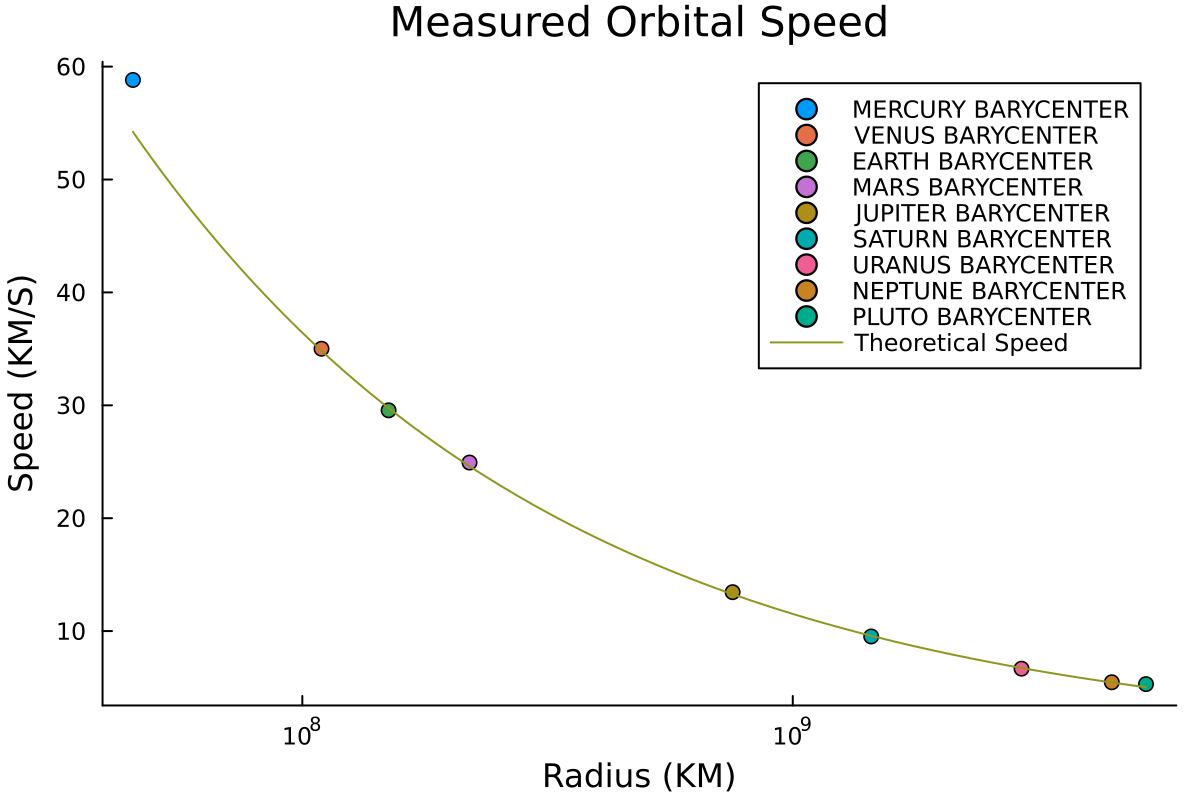

In [12]:
using Plots
using LinearAlgebra

epoch = now()

radius(planet) =
    let state = planet(epoch)
        return sqrt(state.x^2 + state.y^2 + state.z^2)
    end

actual_speed(planet) =
    let state = planet(epoch)
        return sqrt(state.ẋ^2 + state.ẏ^2 + state.ż^2)
    end

ideal_speed(planet) =
    let state = planet(epoch)
        return AstrodynamicalCalculations.orbital_speed(
            state.x,
            state.y,
            state.z,
            state.ẋ,
            state.ẏ,
            state.ż,
            gm(:sun),
        )
    end

artsy = (;
    grid = false,
    markersize = 8,
    dpi = 200,
    xlabel = "Radius (KM)",
    ylabel = "Speed (KM/S)",
    xaxis = :log,
)

fig = plot(; title = "Measured Orbital Speed", artsy...)

for planet in planets
    scatter!(fig, [radius(planet)], [actual_speed(planet)]; label = name(planet))
end

plot!(r -> sqrt(gm(:sun) / r); label = "Theoretical Speed")